In [1]:
import pySPM
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from ipywidgets import interact, fixed
from mpl_toolkits.axes_grid1 import make_axes_locatable, Grid, ImageGrid
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.patches import Rectangle

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['image.cmap'] = 'afmhot'

Define some help functions:

In [2]:
def find_specs(f):
    # f: opened pySPM.Bruker file
    
    drive, freq, phase, defl = (b'@2:CantDriveContactMode',b'@2:CantFrequencyContactMode',
                            b'@2:CantPhaseContactMode',b'@2:AFMSetDeflection')

    drivenum = np.round(float(f.scanners[0][drive][0].decode("utf-8")[21:29]), decimals=1)
    driveunit = f.scanners[0][drive][0].decode("utf-8")[30:]
    
    freqnum = np.round(float(f.scanners[0][freq][0].decode("utf-8")[25:33]), decimals=1)
    frequnit = f.scanners[0][freq][0].decode("utf-8")[34:]

    phasenum = np.round(float(f.scanners[0][phase][0].decode("latin1")[28:30]), decimals=1)
    phaseunit = f.scanners[0][phase][0].decode("latin1")[30:]

    deflnum = np.round(float(f.scanners[0][defl][0].decode("utf-8")[40:49]), decimals=1)
    deflunit = f.scanners[0][defl][0].decode("utf-8")[49:]
    
    res = [(deflnum, deflunit), (drivenum, driveunit), (freqnum, frequnit), 
           (phasenum, phaseunit)]
    
    return res

def print_specs(f, dual=False):
    # f: opened pySPM.Bruker file

    if dual:
        string = r'\textbf{{SP}}={0[0]}{0[1]} | \textbf{{Drive}}={1[0]}{1[1]}'+\
                 '\n'+r'\textbf{{Freq}}.={2[0]}{2[1]} | \textbf{{Phase}}={3[0]}{3[1]}'
    elif not dual:
        string = r'\textbf{{SP}}={0[0]}{0[1]} | \textbf{{Drive}}={1[0]}{1[1]}'+\
                 r'| \textbf{{Freq}}.={2[0]}{2[1]} | \textbf{{Phase}}={3[0]}{3[1]}'
        
    text = string.format(*[(x,y) for (x,y) in find_specs(f)])
    
    return text

def load_4chan(fname, long_titles=False):
    
    f = pySPM.Bruker(fname)
    va = f.get_channel(channel='Amplitude1',backward=True)
    la = f.get_channel(channel='Amplitude2',backward=True)
    vp = f.get_channel(channel='Phase1',backward=True)
    lp = f.get_channel(channel='Phase2',backward=True)
    
    ls = [va, la, vp, lp]
    
    if long_titles:
        titles = ['Vertical Amplitude','Lateral Amplitude', 'Vertical Phase', 'Lateral Phase']
    elif not long_titles:
        titles = ['VA', 'LA', 'VP', 'LP']
    
    res = {}
    for name, value in zip(titles, ls):
        res[name] = value
        
    return f, res

Define a function to plot the four channels in an entry of `filelist` specified by the index `i`:

In [3]:
def plot_pfm(i=0, specs=False, save=False, sample_name='None', fname='None', saveformat='png', sl=np.s_[:,:]):
    """ 
    Must have loaded a list of files called 'filelist' before 
    using this function.
    """
    
    # Load the image channels
    f, chans = load_4chan(filelist[i])
    names = ['VA', 'LA', 'VP', 'LP']
    
    # Crop the img if needed:
    imgs = {}
    for key, arg in chans.items():
        imgs[key] = arg.pixels[sl]
        
    # Compute ratios to keep scalebar also when cropping
    xratio = chans['LA'].pixels.shape[0] / imgs['LA'].shape[0]
    yratio = chans['LA'].pixels.shape[1] / imgs['LA'].shape[1]

    # Initialise a font dictionary
    fdict = dict(verticalalignment='bottom', size='x-large')
    
    # Calculate sizes and units of the pfm image
    xsize = np.round(chans['LA'].size['real']['x'], decimals=1)
    ysize = np.round(chans['LA'].size['real']['y'], decimals=1)
    unit  = chans['LA'].size['real']['unit']
    
    # Initialise the figure and grid
    fig = plt.figure(figsize=(7,7),dpi=100)
    grid = ImageGrid(fig, 111, nrows_ncols=(2,2), axes_pad = 0.1)
    
    # Initialise the scalebar
    fontprops = fm.FontProperties(size=11)
    scalebarlabel = '{0} {1}'.format(np.round(xsize/(xratio*5), decimals=1), unit) 
    scalebar = AnchoredSizeBar(grid[0].transData, xsize*xratio/5, scalebarlabel, 'lower right', 
                               color='white', frameon=False, size_vertical=xsize*xratio/500, pad=0.5,
                               sep=5, fontproperties=fontprops)
    
    # Add labels and the scalebar
    grid[0].add_artist(scalebar)
    grid[0].set_ylabel('Amplitude', fdict)
    grid[0].set_title('Vertical', fdict)
    grid[1].set_title('Lateral', fdict)
    grid[2].set_ylabel('Phase', fdict)
    
    # Plot the images
    for axis, channel in zip(grid, names):
        
        # plot the image
        imgplot = np.flipud(imgs[channel])
        im = axis.imshow(imgplot,vmax=imgplot.max()+imgplot.mean()/2, 
                         interpolation='bilinear', extent=[0, xsize*xratio, 0, ysize*yratio])
        
        # get rid of numbers
        plt.setp(axis.get_xticklabels(), visible=False)
        plt.setp(axis.get_yticklabels(), visible=False)
        
        # get rid of ticks
        axis.tick_params(axis='both', which='both',length=0)

    # Read specs and add it to figure
    if specs:
        text = print_specs(f)
        plt.gcf().text(0.5, 0.08, text, size=10, weight='normal', va='bottom', 
                       ha='center', bbox=dict(boxstyle="round", facecolor='orange', alpha=0.1))

    # Save it 
    if save:
        plt.savefig('/users/zatterin/Documents/phdthesis/notes/samples/imgs/pfm/{0}/{1}.{2}'.format(sample_name,fname,saveformat),
                    dpi=100, bbox_inches='tight', format=saveformat)

In [4]:
afmdir = '/users/zatterin/Documents/data/AFM/kto_pto/'
%ls {afmdir}

e16014/  e16019/  e16050/  e16065/  e16089/  e17049/  e17089/  e18015/
e16018/  e16020/  e16056/  e16088/  e16095/  e17087/  e17090/


In [5]:
sample = 'e16014'
datefolders = !ls {afmdir+sample}
for index, date in enumerate(datefolders): print('{0}...{1}/'.format(index, date)) 

0...01.07.17/
1...24.05/


In [11]:
i = 1
filedir = afmdir+sample+'/'+datefolders[i]+'/'
filelist = !ls {filedir} | grep '00'
for index, name in enumerate(filelist): print('{0}...{1}'.format(index, name))
    
for index in range(len(filelist)): 
    filelist[index] = filedir+filelist[index]

0...e16014.001
1...e16014.002
2...e16014.003
3...e16014.004
4...e16014.005
5...e16014.006
6...e16014.007
7...e16014.008
8...e16014.009


In [12]:
interact(plot_pfm, i=(0, len(filelist)-1, 1), sample_name=str(sample), sl=fixed(np.s_[:,:]));

interactive(children=(IntSlider(value=0, description='i', max=8), Checkbox(value=False, description='specs'), …

In [8]:
# n = 0
# # filedir = subdir+dayfolder[n]+'/'
# subdir = afmdir+sample+'/'+datefolders[n]+'/'
# filelist = !ls {subdir} | grep '0' #| grep {sample}
# for index in range(len(filelist)): 
#     filelist[index] = filedir+filelist[index]
#     print(filelist[index])

Crop the image if you like:

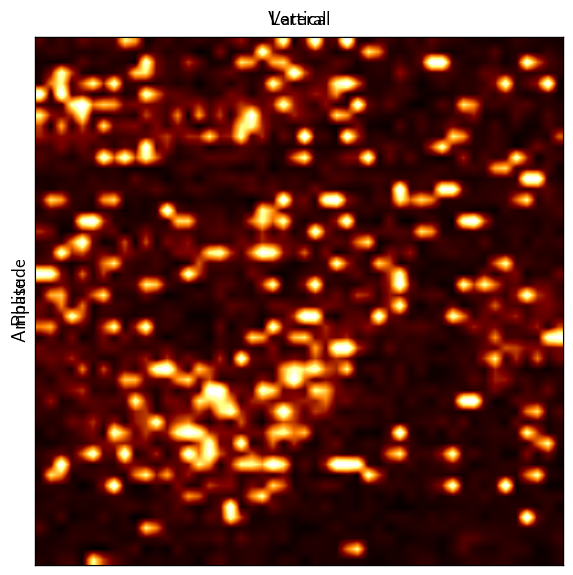

In [9]:
plot_pfm(i=0, save=False, sample_name='e16095', fname='500_110_soft_cropped_2', saveformat='pdf', sl=np.s_[150:200,75:125])

The whole thing to do further mods:

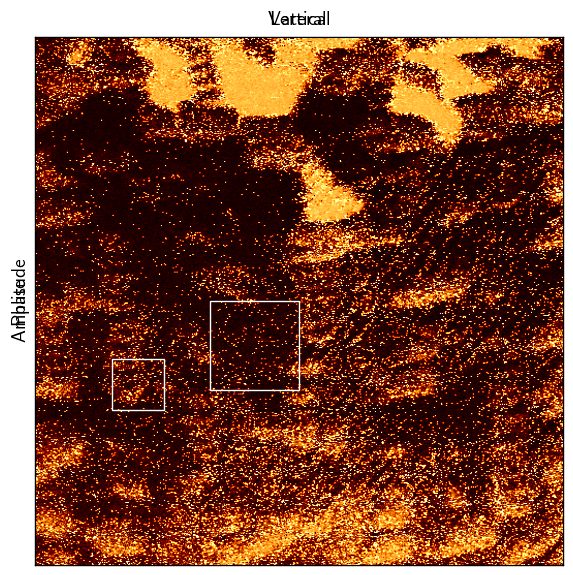

In [31]:
i=0
specs=False
save=False
sample_name='e16095'
fname='500_110_soft_areas'
saveformat='pdf'
sl=np.s_[:,:]

# Load the image channels
f, chans = load_4chan(filelist[i])
names = ['VA', 'LA', 'VP', 'LP']

# Crop the img if needed:
imgs = {}
for key, arg in chans.items():
    imgs[key] = arg.pixels[sl]

# Compute ratios to keep scalebar also when cropping
xratio = chans['LA'].pixels.shape[0] / imgs['LA'].shape[0]
yratio = chans['LA'].pixels.shape[1] / imgs['LA'].shape[1]

# Initialise a font dictionary
fdict = dict(verticalalignment='bottom', size='x-large')

# Calculate sizes and units of the pfm image
xsize = np.round(chans['LA'].size['real']['x'], decimals=1)
ysize = np.round(chans['LA'].size['real']['y'], decimals=1)
unit  = chans['LA'].size['real']['unit']

# Initialise the figure and grid
fig = plt.figure(figsize=(7,7),dpi=100)
grid = ImageGrid(fig, 111, nrows_ncols=(2,2), axes_pad = 0.1)

# Initialise the scalebar
fontprops = fm.FontProperties(size=11)
scalebarlabel = '{0} {1}'.format(np.round(xsize/(xratio*5), decimals=1), unit) 
scalebar = AnchoredSizeBar(grid[0].transData, xsize*xratio/5, scalebarlabel, 'lower right', 
                           color='white', frameon=False, size_vertical=xsize*xratio/500, pad=0.5,
                           sep=5, fontproperties=fontprops)

# Add labels and the scalebar
grid[0].add_artist(scalebar)
grid[0].set_ylabel('Amplitude', fdict)
grid[0].set_title('Vertical', fdict)
grid[1].set_title('Lateral', fdict)
grid[2].set_ylabel('Phase', fdict)

# Plot the images
for index, channel in zip(range(4), names):
    
    # draw rois
    ratio = xsize / imgs[channel].shape[0]
    roi1 = Rectangle((170*ratio,170*ratio), (256-170)*ratio, (256-170)*ratio, 
                     fill=False, edgecolor='white')
    grid[index].add_patch(roi1)
    roi2 = Rectangle((75*ratio,150*ratio), (200-150)*ratio, (125-75)*ratio, 
                     fill=False, edgecolor='white')
    grid[index].add_patch(roi2)

    # plot the image
    imgplot = np.flipud(imgs[channel])
    im = grid[index].imshow(imgplot,vmax=imgplot.max()+imgplot.mean()/2, 
                     interpolation='bilinear', extent=[0, xsize*xratio, 0, ysize*yratio])

    # get rid of numbers
    plt.setp(grid[index].get_xticklabels(), visible=False)
    plt.setp(grid[index].get_yticklabels(), visible=False)

    # get rid of ticks
    grid[index].tick_params(axis='both', which='both',length=0)

# Read specs and add it to figure
if specs:
    text = print_specs(f)
    plt.gcf().text(0.5, 0.08, text, size=10, weight='normal', va='bottom', 
                   ha='center', bbox=dict(boxstyle="round", facecolor='orange', alpha=0.1))

# Save it 
if save:
    plt.savefig('/users/zatterin/Documents/phdthesis/notes/samples/imgs/pfm/{0}/{1}.{2}'.format(sample_name,fname,saveformat),
                dpi=100, bbox_inches='tight', format=saveformat)

In [35]:
grid[3]

## The old way

This is needed for images where the vertical and lateral channel has been collected independently.

In [28]:
sample = 'e16020'
datefolders = !ls {afmdir+sample+'/'}
for index, date in enumerate(datefolders): print('{0}...{1}/'.format(index, date)) 

0...03.05/
1...06.05/
2...07.09/
3...09.05/
4...11.11/
5...NsThumbnails.bin/


In [29]:
i = 3
filedir = afmdir+sample+'/'+datefolders[i]+'/'
filelist = !ls {filedir} | grep '0' | grep {sample}
for index in range(len(filelist)): 
    filelist[index] = filedir+filelist[index]
    print(filelist[index])

/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.014
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.015
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.016
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.017
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.018
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.019
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.020
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.021
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.022
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.023
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.024
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.025
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.026
/users/zatterin/Documents/data/AFM/kto_pto/e16020/09.05/e16020E.027
/users/zatterin/Documents/data/AFM/kto_pto/e1602

In [30]:
@interact(i=(0, len(filelist)-1, 1))
def plot_pfm_old(i=0):
    
    # Read the channels
    f = pySPM.Bruker(filelist[i])
    a = f.get_channel(channel='Amplitude1',backward=True)
    p = f.get_channel(channel='Phase1',backward=True)
    ls = [a, p]
    
    # Read the sizes 
    xsize = a.size['real']['x']
    ysize = a.size['real']['y']
    unit  = a.size['real']['unit']
    
    # Make a font dict
    fdict = dict(verticalalignment='bottom', size='x-large')
    
    # Init figure and grid
    fig = plt.figure(figsize=(7,7),dpi=100)
    grid = ImageGrid(fig, 111, nrows_ncols=(1,2), axes_pad = 0.1)
    
    # Init scalerbar
    fontprops = fm.FontProperties(size=11)
    scalebarlabel = '{0} {1}'.format(np.round(xsize/5, decimals=1), unit) 
    scalebar = AnchoredSizeBar(grid[0].transData, xsize/5, scalebarlabel, 'lower right', 
                               color='white', frameon=False, size_vertical=xsize/500, pad=0.5,
                               sep=5, fontproperties=fontprops)
    
    # Add scalebar and labels
    grid[0].add_artist(scalebar)
    grid[0].set_title('Amplitude', fdict)
    grid[1].set_title('Phase', fdict)
    
    for axis, img in zip(grid, ls):
    
        # Plot the image
        imgplot = np.flipud(img.pixels)
        im = axis.imshow(imgplot,cmap='afmhot',vmax=imgplot.max()+imgplot.mean()/2, 
                         interpolation='bilinear', extent=[0, xsize, 0, ysize])

        # Get rid of numbers
        plt.setp(axis.get_xticklabels(), visible=False)
        plt.setp(axis.get_yticklabels(), visible=False)
        
        # Get rid of ticks
        axis.tick_params(axis='both', which='both',length=0)

interactive(children=(IntSlider(value=0, description='i', max=18), Output()), _dom_classes=('widget-interact',…

## Arrange images

Read amplitude and phase from each image in `filelist`:

In [36]:
files = {}
for index in range(len(filelist)):
    files[index] = {}
    files[index]['f'] = pySPM.Bruker(filelist[index])
    files[index]['a'] = files[index]['f'].get_channel(channel='Amplitude1',backward=True)
    files[index]['p'] = files[index]['f'].get_channel(channel='Phase1',backward=True)

In [37]:
def gridplot(index, fnum, channel):
    img = files[fnum][channel]
    imgplot = np.flipud(img.pixels)
    grid[index].imshow(imgplot, 
                       vmax=imgplot.max()+imgplot.mean()/2, 
                       interpolation='bilinear',
                       extent=[0, xsize, 0, ysize])

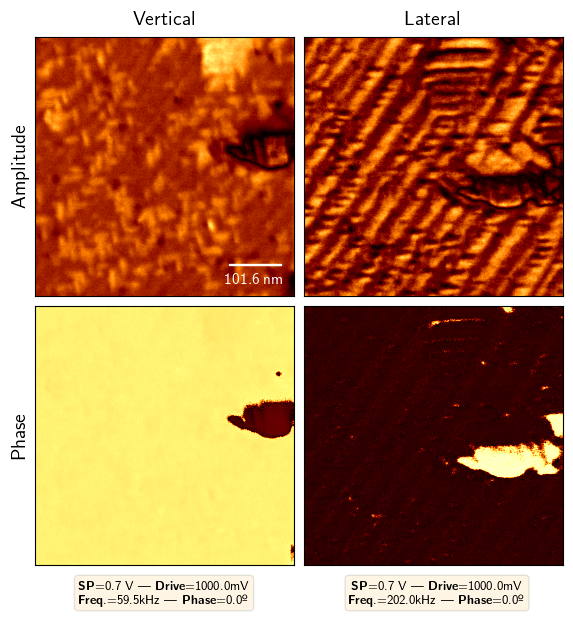

In [42]:
m, n = 6, 4

# Calculate sizes and units of the pfm image
xsize = files[m]['a'].size['real']['x']
ysize = files[m]['a'].size['real']['y']
unit  = files[m]['a'].size['real']['unit']

# Initialise a font dictionary
fdict = dict(verticalalignment='bottom', size='x-large')

# Initialise the figure and grid
fig = plt.figure(figsize=(7,7),dpi=100)
grid = ImageGrid(fig, 111, nrows_ncols=(2,2), axes_pad=0.1)

# Initialise the scalebar
fontprops = fm.FontProperties(size=11)
scalebarlabel = '{0} {1}'.format(np.round(xsize/5, decimals=1), unit) 
scalebar = AnchoredSizeBar(grid[0].transData, xsize/5, scalebarlabel, 'lower right', 
                           color='white', frameon=False, size_vertical=xsize/500, pad=0.5,
                           sep=5, fontproperties=fontprops)

# Add labels and the scalebar
grid[0].add_artist(scalebar)
grid[0].set_ylabel('Amplitude', fdict)
grid[0].set_title('Vertical', fdict)
grid[1].set_title('Lateral', fdict)
grid[2].set_ylabel('Phase', fdict)

# Plot the images
gridplot(0,m,'a')
gridplot(1,n,'a')
gridplot(2,m,'p')
gridplot(3,n,'p')

# Clean up axes
for axis in grid:

    # get rid of numbers
    plt.setp(axis.get_xticklabels(), visible=False)
    plt.setp(axis.get_yticklabels(), visible=False)
    # get rid of ticks
    axis.tick_params(axis='both', which='both',length=0)
    
# read specs from files
text_m = print_specs(files[m]['f'],dual=True)
text_n = print_specs(files[n]['f'],dual=True)
    
# print the specs in the figure
plt.gcf().text(0.32, 0.085, text_m, size=9, weight='normal', va='center', 
               ha='center', bbox=dict(boxstyle="round", facecolor='orange', alpha=0.1))
plt.gcf().text(0.71, 0.085, text_n, size=9, weight='normal', va='center', 
               ha='center', bbox=dict(boxstyle="round", facecolor='orange', alpha=0.1))

fname = '500_mixed'
plt.savefig('/users/zatterin/Documents/phdthesis/notes/structure/imgs/pfm/e16020/{0}.png'.format(fname),dpi=100,bbox_inches='tight')